In [121]:
# 1) Setup - imports and config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 120)

In [122]:
# 2) Load dataset - updated with uploaded file
DATA_PATH = Path('TravClan Assignment.csv')  # updated to uploaded file


df = pd.read_csv(DATA_PATH, parse_dates=True, low_memory=False)

# Quick preview
print('Rows, Columns:', df.shape)
df.head()

Rows, Columns: (30000, 24)


,customer_id,property_id,city,star_rating,booking_date,check_in_date,check_out_date,room_type,num_rooms_booked,stay_type,booking_channel,booking_value,costprice,markup,selling_price,payment_method,refund_status,refund_amount,channel_of_booking,booking_status,travel_date,cashback,coupon_redeem,Coupon USed?
0,492,3,San Francisco,4,2024-04-01,2024-05-24,2024-05-26,Standard,1,Leisure,Mobile App,19361.0,19361,5981,25342,PayPal,Yes,369.648995,Web,Confirmed,2024-03-04,5.374694,0.000000,No
1,180,3,Dallas,3,2024-04-01,2024-05-10,2024-05-17,Deluxe,1,Leisure,Mobile App,6137.0,6137,1896,8033,Bank Transfer,Yes,492.505903,Web,Confirmed,2024-07-19,7.161033,0.000000,No
2,50,5,Dallas,3,2024-04-01,2024-05-31,2024-06-05,Deluxe,1,Business,Web,22702.0,22702,7013,29715,Debit Card,Yes,0.000000,iOS,Confirmed,2024-03-22,0.000000,0.000000,No
3,294,3,Orlando,4,2024-04-01,2024-04-18,2024-04-24,Deluxe,3,Leisure,Web,34068.0,34068,10524,44592,Bank Transfer,Yes,545.541516,Android,Confirmed,2024-11-24,7.932170,24.500442,Yes
4,40,5,Seattle,5,2024-04-01,NaN,NaN,Deluxe,1,Leisure,Mobile App,12127.0,12127,3746,15873,Debit Card,Yes,211.367602,Web,Cancelled,2024-03-02,0.000000,0.000000,No


In [123]:
# Create New Columns
df['booking_date'] = pd.to_datetime(df['booking_date'], errors='coerce')
df['check_in_date'] = pd.to_datetime(df['check_in_date'], errors='coerce')

df['lead_time'] = (df['check_in_date'] - df['booking_date']).dt.days
df['is_canceled'] = df['booking_status'].str.lower().eq('cancelled').astype(int)


In [124]:
# 4) Initial checks - dtypes, nulls, duplicates
print('\nColumn dtypes:')
print(df.dtypes)

print('\nMissing values (%):')
missing = (df.isna().sum() / len(df) * 100).sort_values(ascending=False)
print(missing[missing>0])

print('\nDuplicate rows:')
print(df.duplicated().sum())

# Create a copy for cleaning steps
data = df.copy()


Column dtypes:
customer_id                    int64
property_id                    int64
city                          object
star_rating                    int64
booking_date          datetime64[ns]
check_in_date         datetime64[ns]
check_out_date                object
room_type                     object
num_rooms_booked               int64
stay_type                     object
booking_channel               object
booking_value                float64
costprice                      int64
markup                         int64
selling_price                  int64
payment_method                object
refund_status                 object
refund_amount                float64
channel_of_booking            object
booking_status                object
travel_date                   object
cashback                     float64
coupon_redeem                float64
Coupon USed?                  object
lead_time                    float64
is_canceled                    int32
dtype: object

Missing

In [125]:
# Numeric summary
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric summary:")
print(df[numeric_cols].describe().T)

# Cancellation rate
if 'booking_status' in df.columns:
    cancel_rate = (df['booking_status'].str.lower() == 'cancelled').mean()
    print(f"\nOverall cancellation rate: {cancel_rate:.2%}")



Numeric summary:
                    count          mean           std          min         25%           50%           75%  \
customer_id       30000.0    249.721767    145.484836     1.000000    123.0000    248.000000    376.000000   
property_id       30000.0      3.777533      2.081471     1.000000      1.0000      3.000000      5.000000   
star_rating       30000.0      3.602033      0.860241     2.000000      3.0000      4.000000      4.000000   
num_rooms_booked  30000.0      1.352333      0.574403     1.000000      1.0000      1.000000      2.000000   
booking_value     30000.0  25080.525454  11587.369335  1279.770000  15922.7125  24736.145000  33570.000000   
costprice         30000.0  22541.494100   9259.520787  3822.000000  15088.7500  22731.000000  30427.000000   
markup            30000.0   6963.324400   2860.106570  1181.000000   4661.7500   7021.500000   9399.000000   
selling_price     30000.0  29504.818500  12119.627338  5003.000000  19750.5000  29752.500000  39826.00

In [126]:
# # Ensure lead_time exists
df['lead_time'] = (df['check_in_date'] - df['booking_date']).dt.days

# Create cancellation flag (handles 'Cancelled' correctly)
df['is_canceled'] = df['booking_status'].str.strip().str.lower().eq('cancelled').astype(int)

# Cancellation rate by lead time bins
lead_cancel = (
    df.groupby(pd.cut(df['lead_time'], bins=10))['is_canceled']
    .mean()
)
print("\nCancellation rate by lead time bins:")
print(lead_cancel)

# Cancellation rate by weekday of check-in
df['checkin_weekday'] = df['check_in_date'].dt.day_name()
weekday_cancel = (df.groupby('checkin_weekday')['is_canceled'].mean().sort_values(ascending=False))
print("\nCancellation rate by check-in weekday:")
print(weekday_cancel)



Cancellation rate by lead time bins:
lead_time
(0.941, 6.9]    0.041851
(6.9, 12.8]     0.043548
(12.8, 18.7]    0.045256
(18.7, 24.6]    0.038847
(24.6, 30.5]    0.039555
(30.5, 36.4]    0.042219
(36.4, 42.3]    0.038525
(42.3, 48.2]    0.046217
(48.2, 54.1]    0.040816
(54.1, 60.0]    0.040765
Name: is_canceled, dtype: float64

Cancellation rate by check-in weekday:
checkin_weekday
Friday       0.050819
Monday       0.042693
Saturday     0.042395
Wednesday    0.042213
Tuesday      0.038983
Thursday     0.038582
Sunday       0.036401
Name: is_canceled, dtype: float64


C:\Users\samar\AppData\Local\Temp\ipykernel_13168\2193520992.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(df['lead_time'], bins=10))['is_canceled']


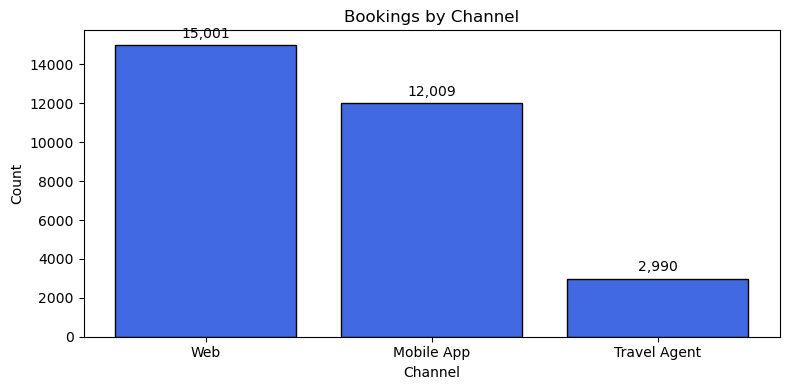

In [134]:
# Plot 1: Booking volume by channel
channel_counts = df['booking_channel'].value_counts()
fig, ax = plt.subplots(figsize=(8,4))
bars = ax.bar(channel_counts.index, channel_counts.values, color='royalblue', edgecolor='black')
ax.bar_label(bars, labels=[f"{v:,}" for v in channel_counts.values], padding=3)
ax.set_title("Bookings by Channel")
ax.set_xlabel("Channel")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

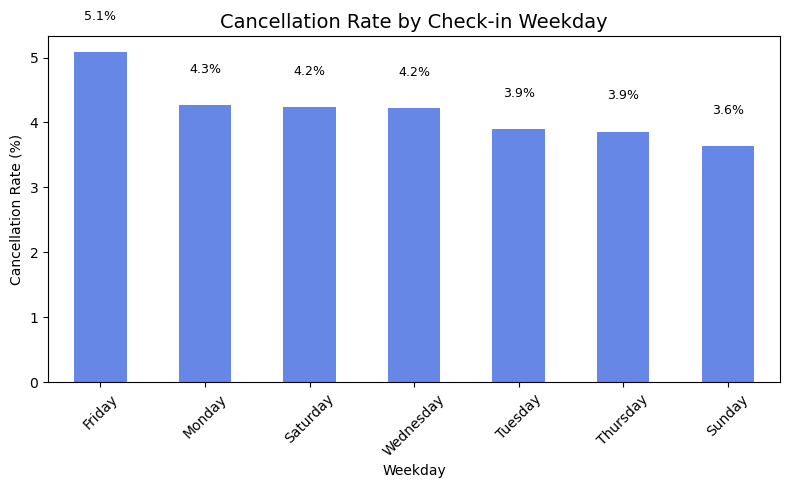

In [133]:
# Weekday Cancellation Rates
weekday_cancel = (
    df.groupby('checkin_weekday')['is_canceled'].mean().sort_values(ascending=False) * 100
)

plt.figure(figsize=(8,5))
weekday_cancel.plot(kind='bar', color='royalblue', alpha=0.8)

for i, val in enumerate(weekday_cancel):
    plt.text(i, val+0.5, f"{val:.1f}%", ha='center', fontsize=9)

plt.title("Cancellation Rate by Check-in Weekday", fontsize=14)
plt.xlabel("Weekday")
plt.ylabel("Cancellation Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


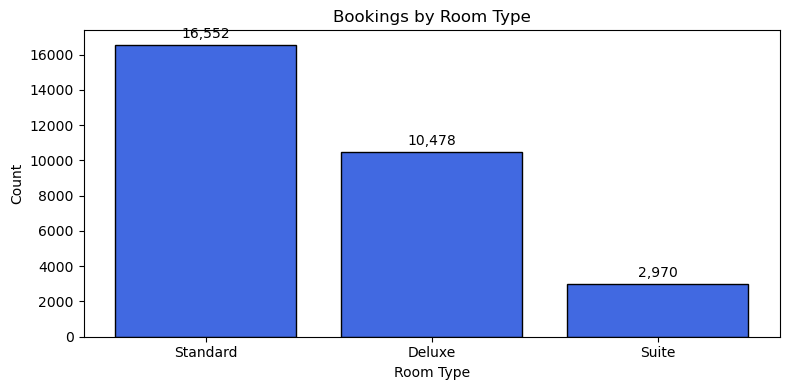

In [131]:
# Plot 3: Booking volume by room type
room_counts = df['room_type'].value_counts()
fig, ax = plt.subplots(figsize=(8,4))
bars = ax.bar(room_counts.index, room_counts.values, color='royalblue', edgecolor='black')
ax.bar_label(bars, labels=[f"{v:,}" for v in room_counts.values], padding=3)
ax.set_title("Bookings by Room Type")
ax.set_xlabel("Room Type")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

C:\Users\samar\AppData\Local\Temp\ipykernel_13168\842357665.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lead_cancel = df.groupby(pd.cut(df['lead_time'], bins=10))['is_canceled'].mean() * 100


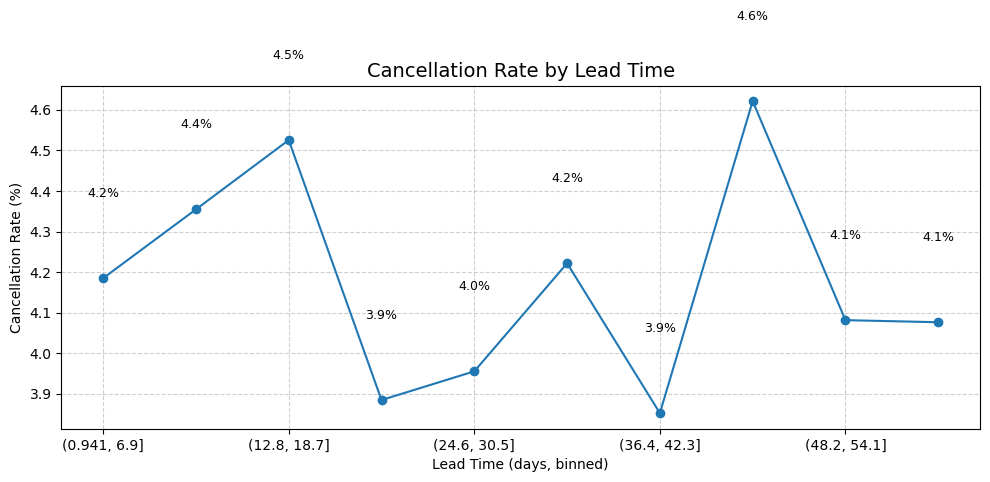

In [ ]:
# Plot 4: Cancellation rate by room type
# Lead Time Cancellation Trend
lead_cancel = df.groupby(pd.cut(df['lead_time'], bins=10))['is_canceled'].mean() * 100

plt.figure(figsize=(10,5))
lead_cancel.plot(kind='line', marker='o', color='tab:skyblue')
for i, val in enumerate(lead_cancel):
    plt.text(i, val+0.2, f"{val:.1f}%", ha='center', fontsize=9)

plt.title("Cancellation Rate by Lead Time", fontsize=14)
plt.xlabel("Lead Time (days, binned)")
plt.ylabel("Cancellation Rate (%)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

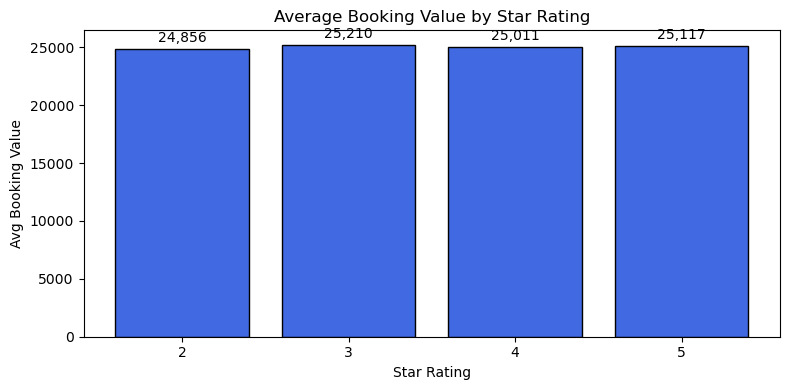

In [130]:
# Plot 5: Booking value by star rating (average)
avg_value_by_star = df.groupby('star_rating')['booking_value'].mean()
fig, ax = plt.subplots(figsize=(8,4))
bars = ax.bar(avg_value_by_star.index.astype(str), avg_value_by_star.values, color='royalblue', edgecolor='black')
ax.bar_label(bars, labels=[f"{v:,.0f}" for v in avg_value_by_star.values], padding=3)
ax.set_title("Average Booking Value by Star Rating")
ax.set_xlabel("Star Rating")
ax.set_ylabel("Avg Booking Value")
plt.tight_layout()
plt.show()

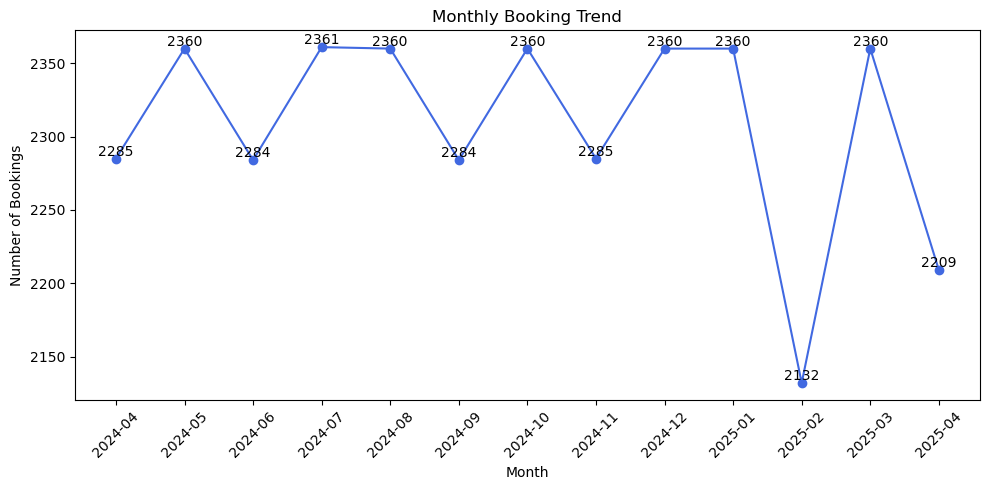

In [ ]:
# Ensure booking_date is datetime
df['booking_date'] = pd.to_datetime(df['booking_date'], errors='coerce')

# Now redo monthly trend
monthly = df.groupby(df['booking_date'].dt.to_period('M')).size()
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(monthly.index.astype(str), monthly.values, marker='o', color='skyblue')
for x, y in zip(monthly.index.astype(str), monthly.values):
    ax.text(x, y, str(y), ha='center', va='bottom')
ax.set_title("Monthly Booking Trend")
ax.set_xlabel("Month")
ax.set_ylabel("Number of Bookings")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# 8) Root cause analysis templates - correlation and pivot checks
# Correlation numeric
if len(numeric_cols) > 1:
    corr = data[numeric_cols].corr()
    print('\nNumeric correlation matrix (top correlations):')
    print(corr.abs().unstack().sort_values(ascending=False).drop_duplicates().head(10))


Numeric correlation matrix (top correlations):
customer_id    customer_id      1.000000
selling_price  costprice        1.000000
markup         selling_price    1.000000
costprice      markup           1.000000
property_id    cashback         0.691269
markup         booking_value    0.630434
booking_value  selling_price    0.630434
costprice      booking_value    0.630434
refund_amount  cashback         0.238590
coupon_redeem  cashback         0.091021
dtype: float64



Reduce Cancellations
 1. Introduce non-refundable or partially refundable rate classes for long-lead bookings
 2. Offer rescheduling credit instead of refund
 3. Targeted communication reminders for bookings with high lead time

Profitability
 1. Push direct bookings via loyalty discounts
 2. Dynamic packaging and upsell at checkout
 3. Optimize OTA commissions by channel mix analysis

Pricing Channel
 1. Run A/B tests for limited-time discounts on underperforming channels
 2. Seasonal price adjustments using monthly demand windows


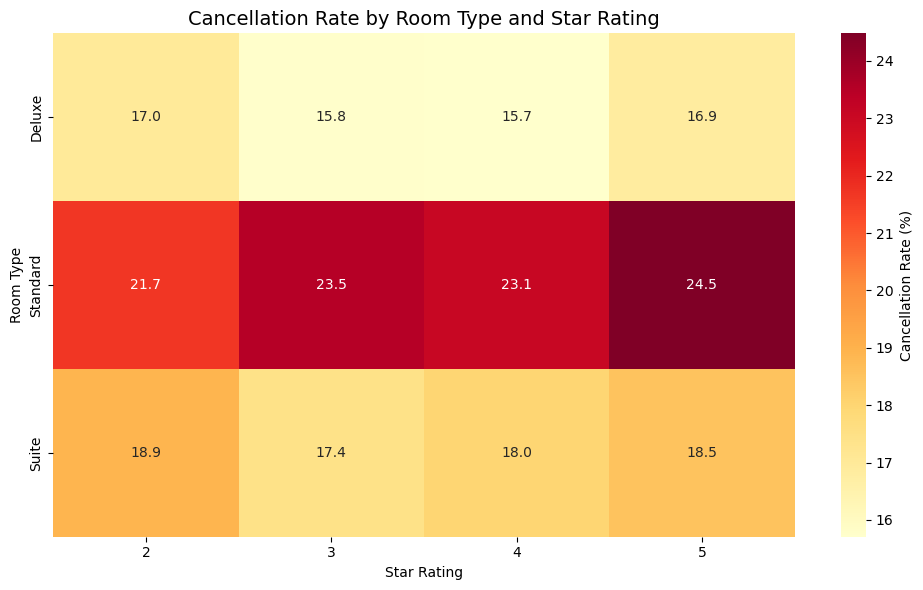

In [ ]:
# 9) Business recommendations - placeholder for structured text
recommendations = {
    'reduce_cancellations': [
        'Introduce non-refundable or partially refundable rate classes for long-lead bookings',
        'Offer rescheduling credit instead of refund',
        'Targeted communication reminders for bookings with high lead time'
    ],
    'profitability': [
        'Push direct bookings via loyalty discounts',
        'Dynamic packaging and upsell at checkout',
        'Optimize OTA commissions by channel mix analysis'
    ],
    'pricing_channel': [
        'Run A/B tests for limited-time discounts on underperforming channels',
        'Seasonal price adjustments using monthly demand windows'
    ]
}

# Print recommendations summary
for k,v in recommendations.items():
    print(f"\n{k.replace('_',' ').title()}")
    for i,rec in enumerate(v,1):
        print(f" {i}. {rec}")


# Pivot table
pivot = df.pivot_table(index='room_type', 
                       columns='star_rating', 
                       values='is_canceled', 
                       aggfunc='mean') * 100  # % terms

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Cancellation Rate (%)'})
plt.title("Cancellation Rate by Room Type and Star Rating", fontsize=14)
plt.xlabel("Star Rating")
plt.ylabel("Room Type")
plt.tight_layout()
plt.show()